Vamos a hacer un Clustering jerárquico, para una temporada

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pathlib import Path

def preparar_datos_para_clustering(df, columnas_excluir=None):
    """
    Prepara un DataFrame para clustering jerárquico:
    - Filtra numéricas
    - Divide por el número de jornadas según la liga
    - Aplica StandardScaler

    Parámetros:
    - df: DataFrame original con columna 'Liga'
    - columnas_excluir: lista de columnas a mantener fuera (ID, etiquetas)

    Retorna:
    - df_escalado: array numpy listo para clustering
    - df_escalado_df: DataFrame escalado con índice original
    - df_normalizado: DataFrame normalizado por jornadas
    """
    if columnas_excluir is None:
        columnas_excluir = []

    # Diccionario de jornadas por liga
    jornadas_por_liga = {
        'Bundesliga': 34,
        'Femenino': 30,
        'La Liga': 38,
        'Ligue 1': 34,  # Nota: Ligue 1 tiene 34 jornadas, no 38
        'Premier League': 38,
        'Serie A': 38
    }

    # Separar columnas excluidas
    df_excluir = df[columnas_excluir] if columnas_excluir else pd.DataFrame(index=df.index)

    # Seleccionar solo numéricas no excluidas
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=columnas_excluir, errors='ignore')

    # Normalizar por el número de jornadas según la liga
    df_normalizado = df_numeric.astype(float).copy()
    
    for liga, jornadas in jornadas_por_liga.items():
        # Encontrar índices de equipos de esta liga
        indices_liga = df[df['liga'] == liga].index
        # Dividir las estadísticas por el número de jornadas
        df_normalizado.loc[indices_liga] = df_numeric.loc[indices_liga] / jornadas

    # Escalar
    scaler = StandardScaler()
    df_escalado = scaler.fit_transform(df_normalizado)

    # Convertimos a DataFrame para conservar estructura
    df_escalado_df = pd.DataFrame(df_escalado, index=df.index, columns=df_normalizado.columns)

    return df_escalado, df_escalado_df, df_normalizado

In [2]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

def dendograma_jerarquico(X, metodo='ward', titulo='Dendograma jerárquico'):
    """
    Genera un dendrograma jerárquico
    - X: datos escalados
    - metodo: método de linkage (ward, complete, average, etc.)
    """
    plt.figure(figsize=(14, 6))
    linkage_matrix = sch.linkage(X, method=metodo)
    sch.dendrogram(linkage_matrix)
    plt.title(titulo)
    plt.xlabel('Observaciones')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()


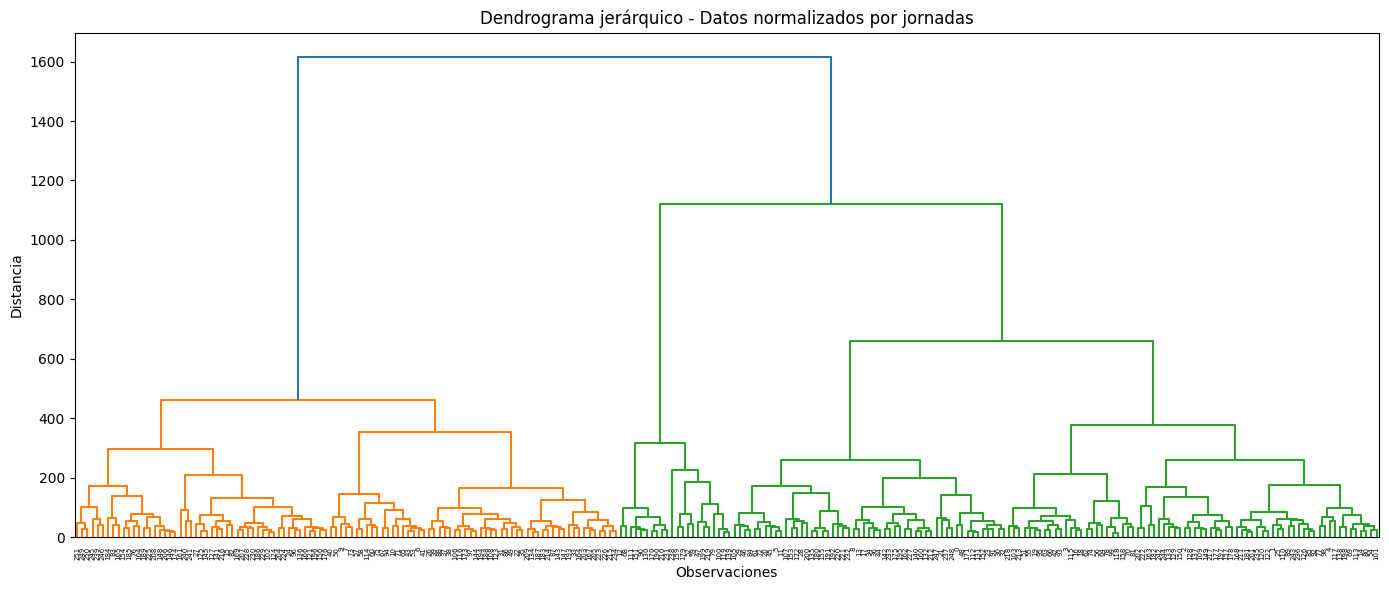

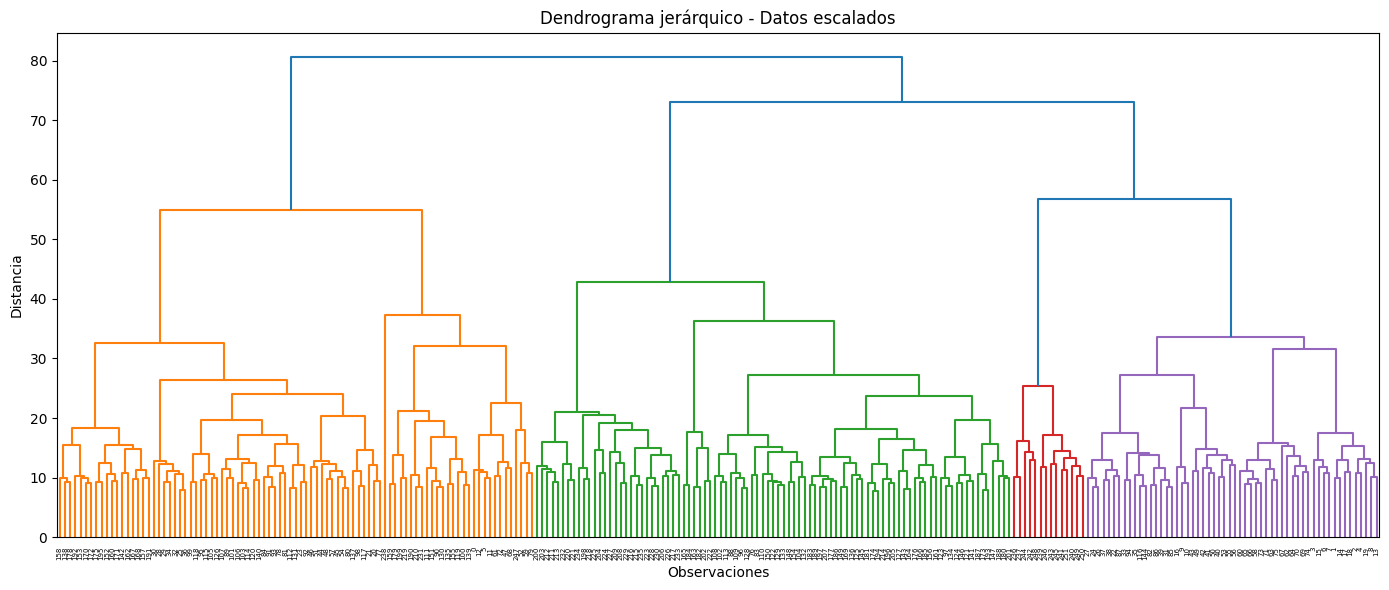

In [4]:
# Cargar datos
# Ruta base = carpeta raíz del proyecto (padre de src/)
# Ruta base = carpeta raíz del proyecto (ajústala según tu estructura)
BASE_DIR = Path.cwd().parent  # Asume que el notebook está en src/ y la raíz es la carpeta padre
INPUT_FILE = BASE_DIR / "output" / "Correlation" / "filtered_features.csv"

df = pd.read_csv(INPUT_FILE)
# Preprocesar (excluyendo columnas no numéricas o IDs)
X, df_ready, X_90 = preparar_datos_para_clustering(df)#, columnas_excluir=["Squad", "season"])

# Mostrar dendrograma
dendograma_jerarquico(X_90,titulo='Dendrograma jerárquico - Datos normalizados por jornadas')
dendograma_jerarquico(X,titulo='Dendrograma jerárquico - Datos escalados')

In [5]:
# Generar una tabla resumen con el nombre de las ligas y el número de equipos por liga
tabla_ligas = df.groupby('liga').size().reset_index(name='Num_equipos')
print(tabla_ligas)

             liga  Num_equipos
0      Bundesliga           18
1        Femenino           16
2         La Liga          160
3         Ligue 1           18
4  Premier League           20
5         Serie A           20


Añadimos nombre y temporada para cada equipo, buscando así una mejor identificación.

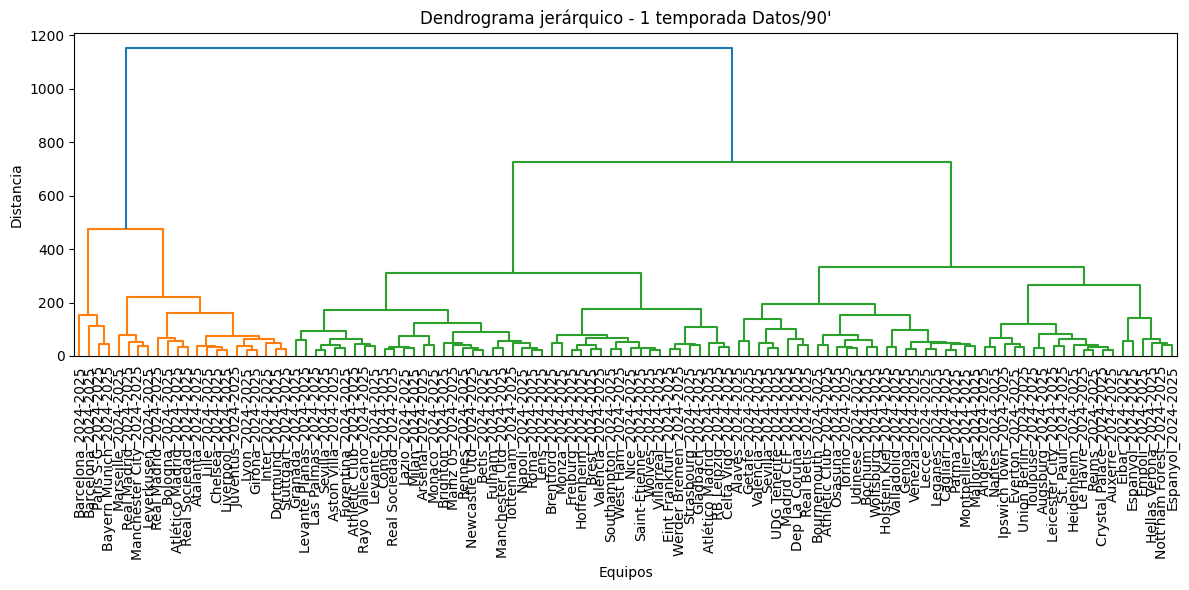

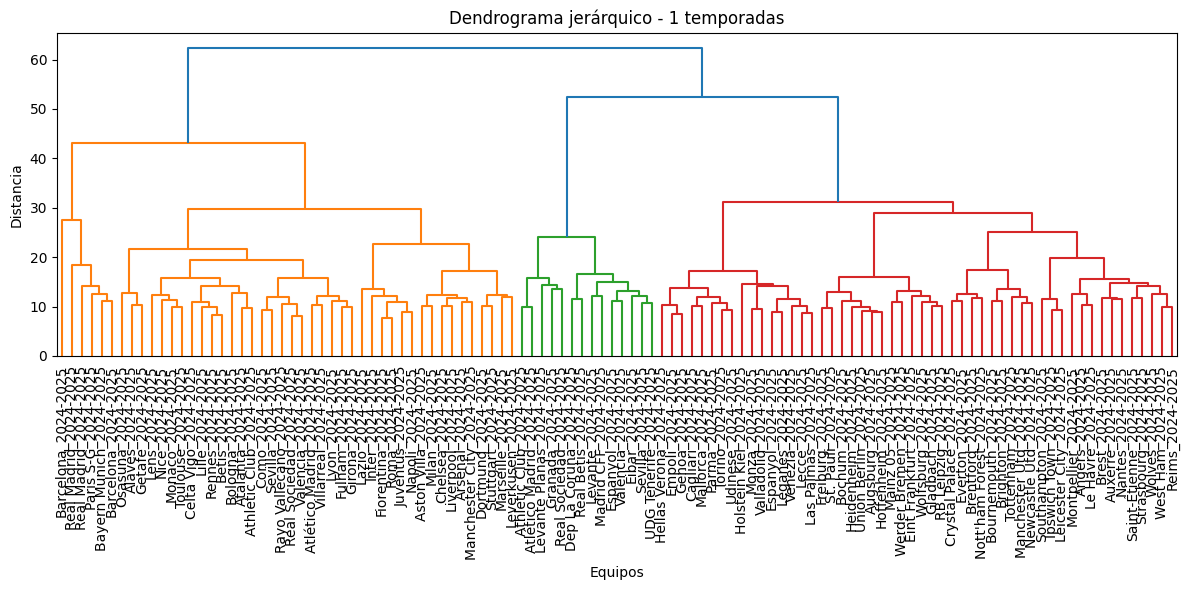

In [7]:

df_2425=df[df['season'] == '2024-2025']  # Filtrar por temporada específica
df["Equipo_Temporada"] = df["Squad"] + "_" + df["season"].astype(str)
# Preprocesar (excluyendo columnas no numéricas o IDs)
X_2425, df_ready, X_90_2425 = preparar_datos_para_clustering(df_2425, columnas_excluir=["Squad", "season","liga"])
plt.figure(figsize=(12, 6))
linkage_matrix = sch.linkage(X_90_2425, method='ward')

sch.dendrogram(
    linkage_matrix,
    labels=df_2425["Equipo_Temporada"].tolist(),
    leaf_rotation=90,
    leaf_font_size=10
)

plt.title("Dendrograma jerárquico - 1 temporada Datos/90'")
plt.xlabel("Equipos")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
linkage_matrix = sch.linkage(X_2425, method='ward')
sch.dendrogram(
    linkage_matrix,
    labels=df_2425["Equipo_Temporada"].tolist(),
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title("Dendrograma jerárquico - 1 temporadas")
plt.xlabel("Equipos")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()



In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, fcluster, cophenet
from scipy.spatial.distance import pdist

def evaluar_clusters_jerarquico(X, metodo="ward", rango_clusters=range(2, 10)):
    """
    Evalúa métricas de calidad para clustering jerárquico, genera gráficos y marca el mejor número de clusters.
    X: numpy array o DataFrame con solo variables numéricas
    """
    Z = linkage(X, method=metodo)
    coph_corr, _ = cophenet(Z, pdist(X))

    resultados = {"k": [], "Silhouette": [], "Calinski-Harabasz": [], "Davies-Bouldin": []}

    for k in rango_clusters:
        labels = fcluster(Z, k, criterion="maxclust")
        resultados["k"].append(k)
        resultados["Silhouette"].append(silhouette_score(X, labels))
        resultados["Calinski-Harabasz"].append(calinski_harabasz_score(X, labels))
        resultados["Davies-Bouldin"].append(davies_bouldin_score(X, labels))

    df_resultados = pd.DataFrame(resultados)

    # Identificar mejores k
    best_sil = df_resultados.loc[df_resultados["Silhouette"].idxmax(), "k"]
    best_ch = df_resultados.loc[df_resultados["Calinski-Harabasz"].idxmax(), "k"]
    best_db = df_resultados.loc[df_resultados["Davies-Bouldin"].idxmin(), "k"]

    # Columnas de "óptimo"
    df_resultados["Best_Silhouette"] = df_resultados["k"] == best_sil
    df_resultados["Best_CH"] = df_resultados["k"] == best_ch
    df_resultados["Best_DBI"] = df_resultados["k"] == best_db

    # ==== Gráficos ====
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].plot(df_resultados["k"], df_resultados["Silhouette"], marker="o")
    axs[0].axvline(best_sil, color="r", linestyle="--", label=f"Mejor k={best_sil}")
    axs[0].set_title("Silhouette Score")
    axs[0].set_xlabel("Número de clusters")
    axs[0].set_ylabel("Silhouette")
    axs[0].legend()

    axs[1].plot(df_resultados["k"], df_resultados["Calinski-Harabasz"], marker="o")
    axs[1].axvline(best_ch, color="g", linestyle="--", label=f"Mejor k={best_ch}")
    axs[1].set_title("Calinski-Harabasz Index")
    axs[1].set_xlabel("Número de clusters")
    axs[1].legend()

    axs[2].plot(df_resultados["k"], df_resultados["Davies-Bouldin"], marker="o")
    axs[2].axvline(best_db, color="b", linestyle="--", label=f"Mejor k={best_db}")
    axs[2].set_title("Davies-Bouldin Index (más bajo es mejor)")
    axs[2].set_xlabel("Número de clusters")
    axs[2].legend()

    plt.suptitle(f"Evaluación Clustering Jerárquico (linkage='{metodo}')\nCophenetic Corr = {coph_corr:.3f}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return df_resultados, coph_corr

import pandas as pd

def evaluar_por_liga(df, metodo="ward", rango_clusters=range(2, 6), columna_liga="liga"):
    """
    Evalúa clustering jerárquico global y por cada liga, generando un resumen tabular.
    df: DataFrame escalado con columna 'liga'
    """
    resultados_ligas = {}
    tablas_resumen = []

    # ==== GLOBAL ====
    print("\n=== Análisis GLOBAL ===")
    X_global = df.drop(columns=[columna_liga])  # solo numéricas
    res_global, coph_global = evaluar_clusters_jerarquico(X_global, metodo=metodo, rango_clusters=rango_clusters)
    res_global["liga"] = "GLOBAL"
    tablas_resumen.append(res_global)

    # ==== POR LIGA ====
    for liga in df[columna_liga].unique():
        print(f"\n=== Análisis {liga} ===")
        subset = df[df[columna_liga] == liga].drop(columns=[columna_liga])
        if subset.shape[0] > max(rango_clusters):  # suficiente cantidad de equipos
            res_liga, coph_liga = evaluar_clusters_jerarquico(subset, metodo=metodo, rango_clusters=rango_clusters)
            res_liga["liga"] = liga
            resultados_ligas[liga] = {"resultados": res_liga, "coph": coph_liga}
            tablas_resumen.append(res_liga)
        else:
            print(f"⚠️ Liga {liga} ignorada: muy pocos equipos para {max(rango_clusters)} clusters")

    # ==== Crear tabla consolidada ====
    df_tabla_final = pd.concat(tablas_resumen, ignore_index=True)
    # Reordenar columnas para más claridad
    columnas_orden = ["liga", "k", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin",
                      "Best_Silhouette", "Best_CH", "Best_DBI"]
    df_tabla_final = df_tabla_final[columnas_orden]

    return res_global, coph_global, resultados_ligas, df_tabla_final


## Revisamos los índices para los datos normalizados ##

   Tackles TklW_for  Tackles Def 3rd_for  Tackles Mid 3rd_for  \
0         -0.765938            -1.385275             0.092108   
1         -0.363632            -0.105453             0.092108   
2          0.088964            -0.158048             1.698480   
3         -0.229529            -0.175580            -0.743206   
4          0.625373            -0.210644             1.634225   

   Tackles Att 3rd_for  Challenges Tkl_for  Challenges Lost_for  \
0             1.909776           -0.761004            -0.400957   
1             0.325878            0.376446            -0.828874   
2             0.651975            0.171705             1.198102   
3             1.537094            0.467442             0.207136   
4             1.537094            1.286405             1.806194   

   Blocks Blocks_for  Blocks Sh_for  Blocks Pass_for  \
0          -1.493042      -0.526207        -1.636244   
1          -1.474586      -0.494417        -1.636244   
2           0.924682       0.427508   

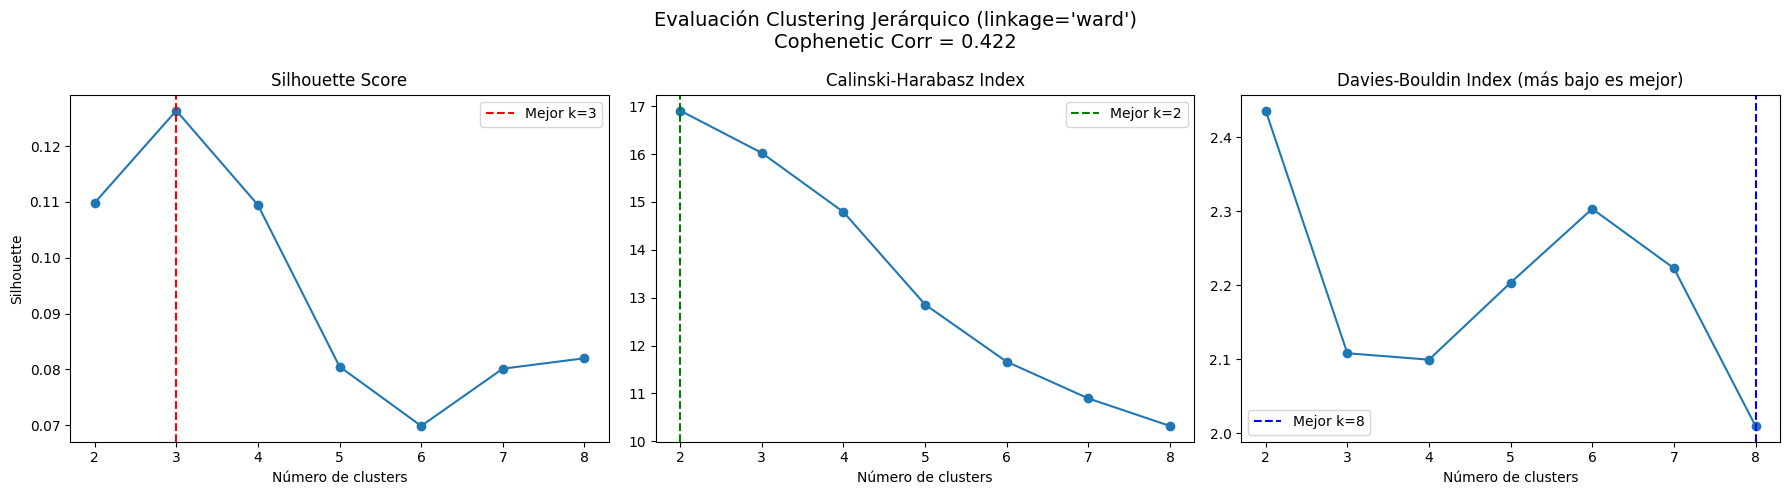


=== Análisis Premier League ===


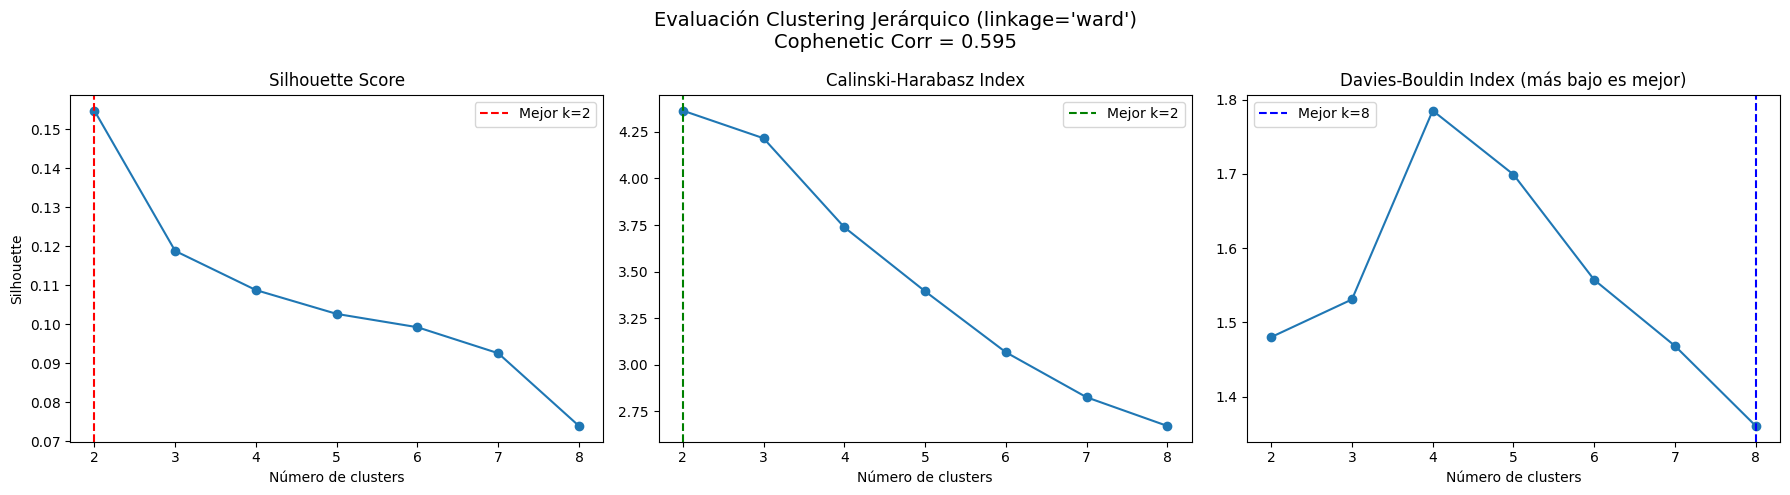


=== Análisis Serie A ===


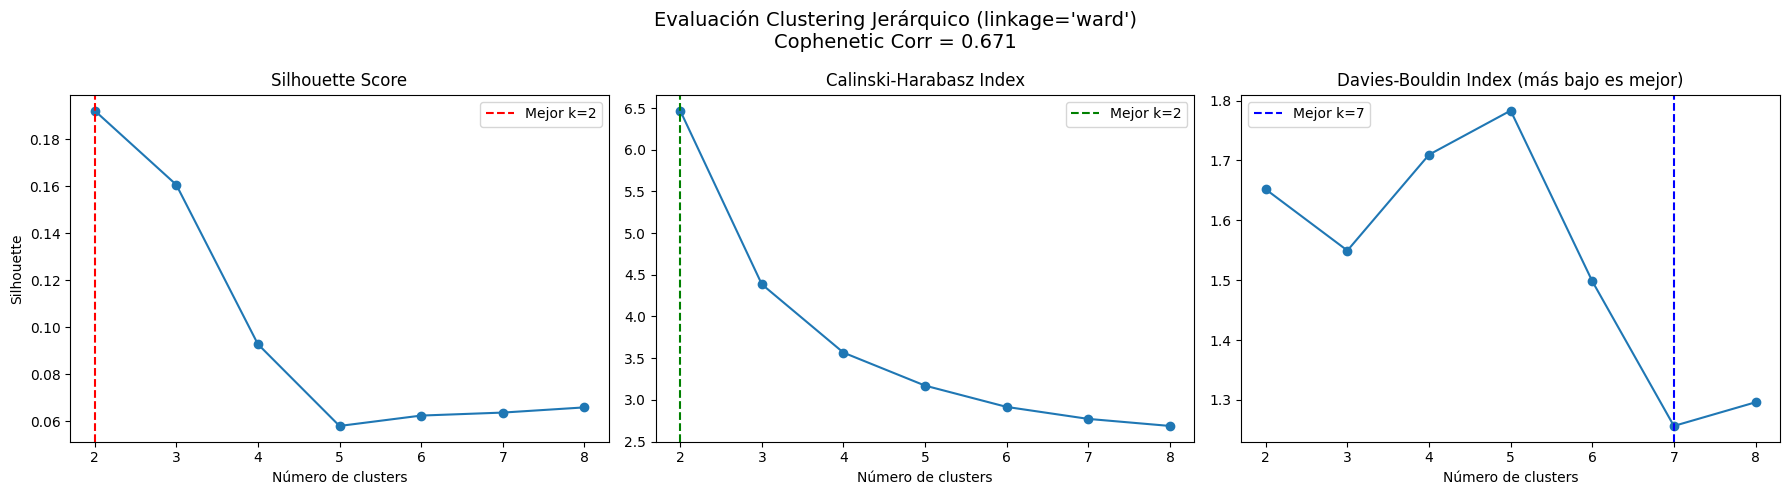


=== Análisis Ligue 1 ===


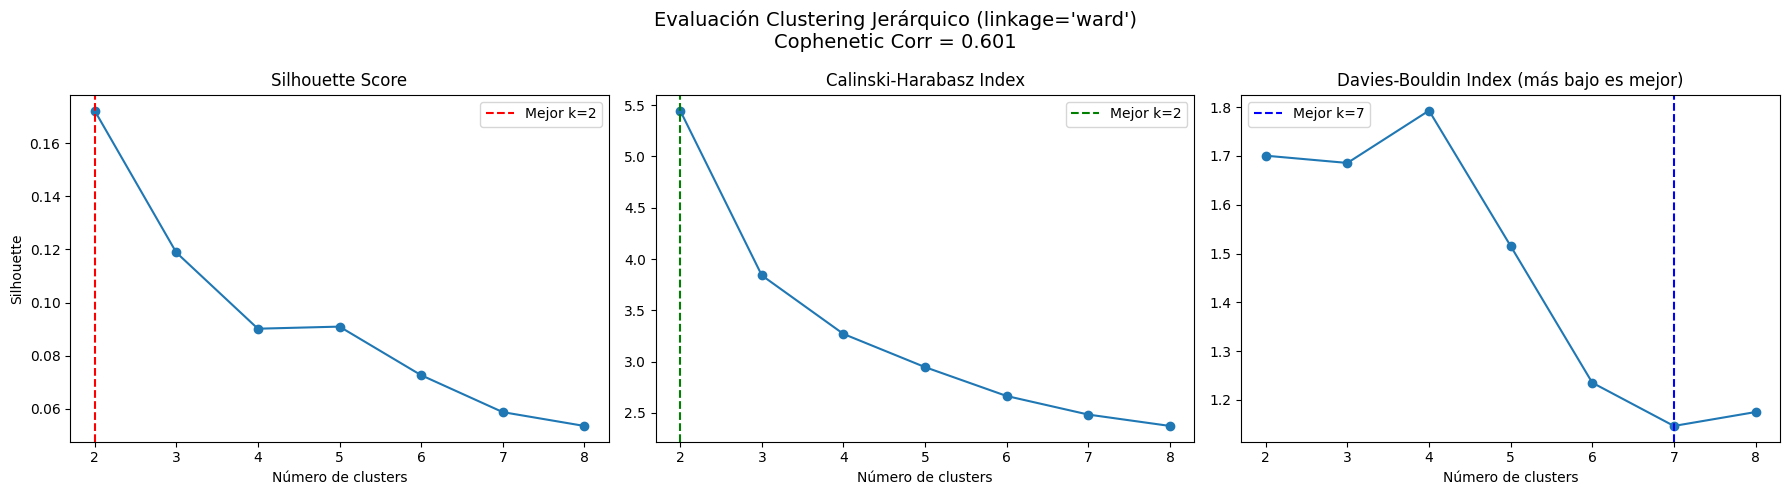


=== Análisis Bundesliga ===


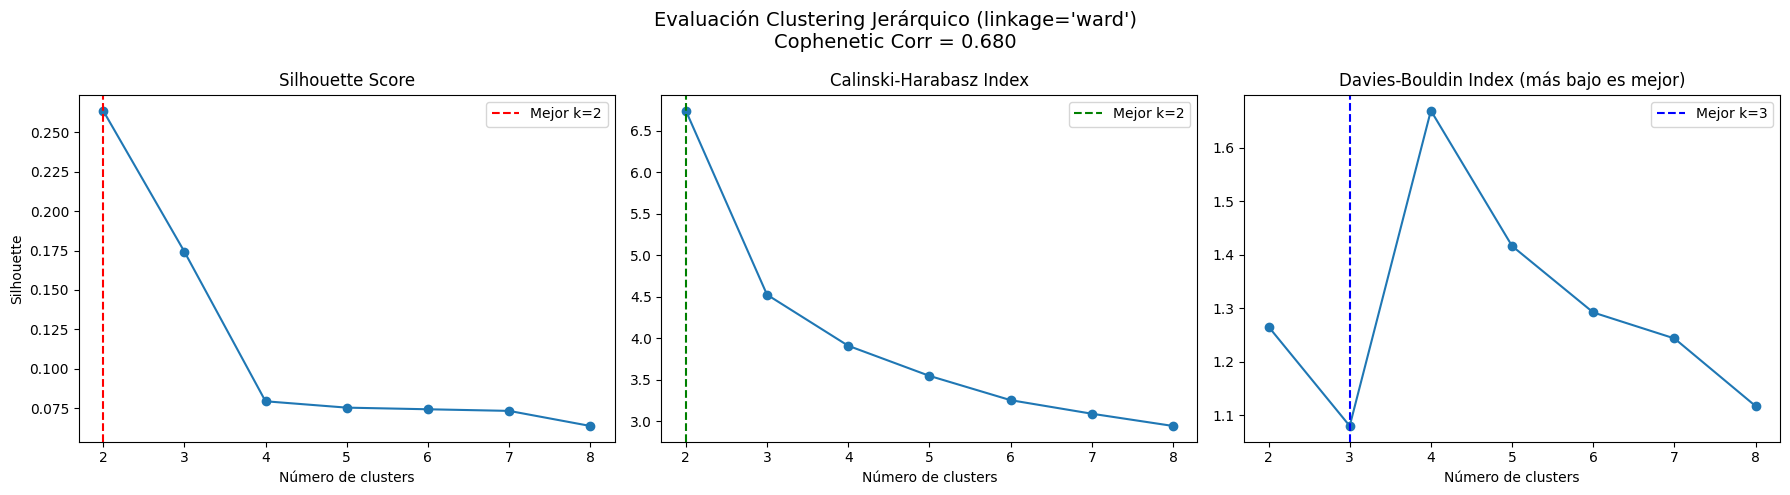


=== Análisis La Liga ===


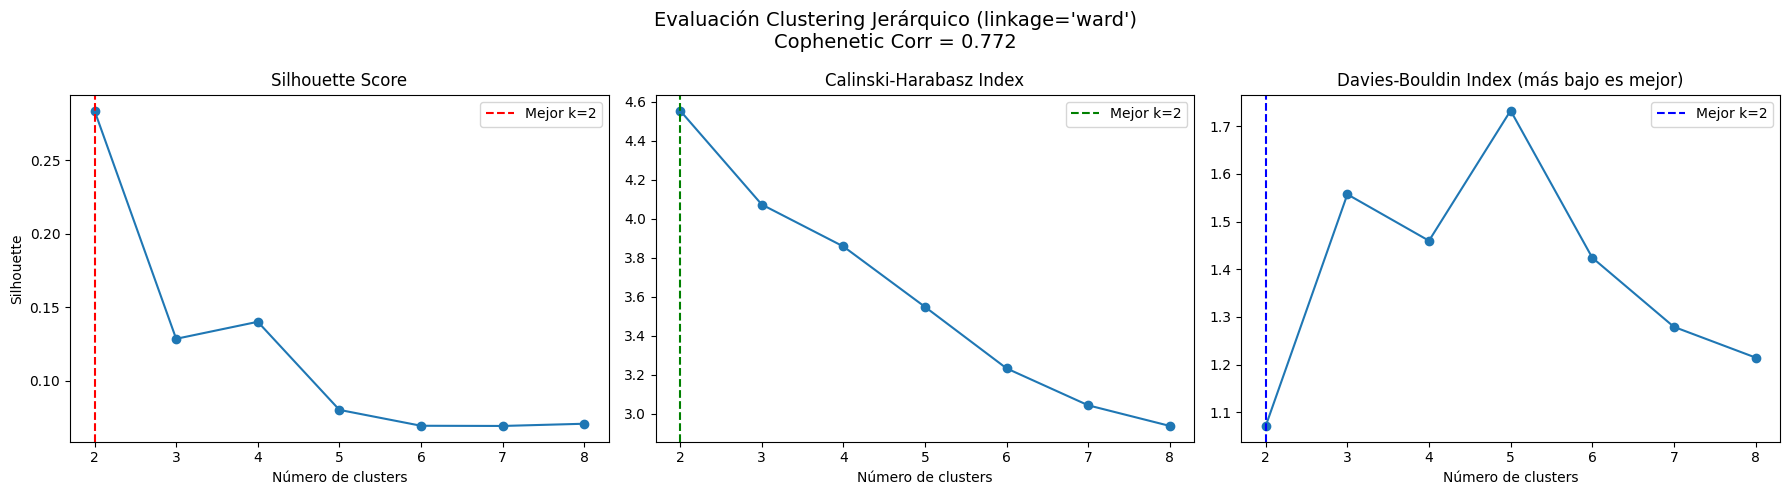


=== Análisis Femenino ===


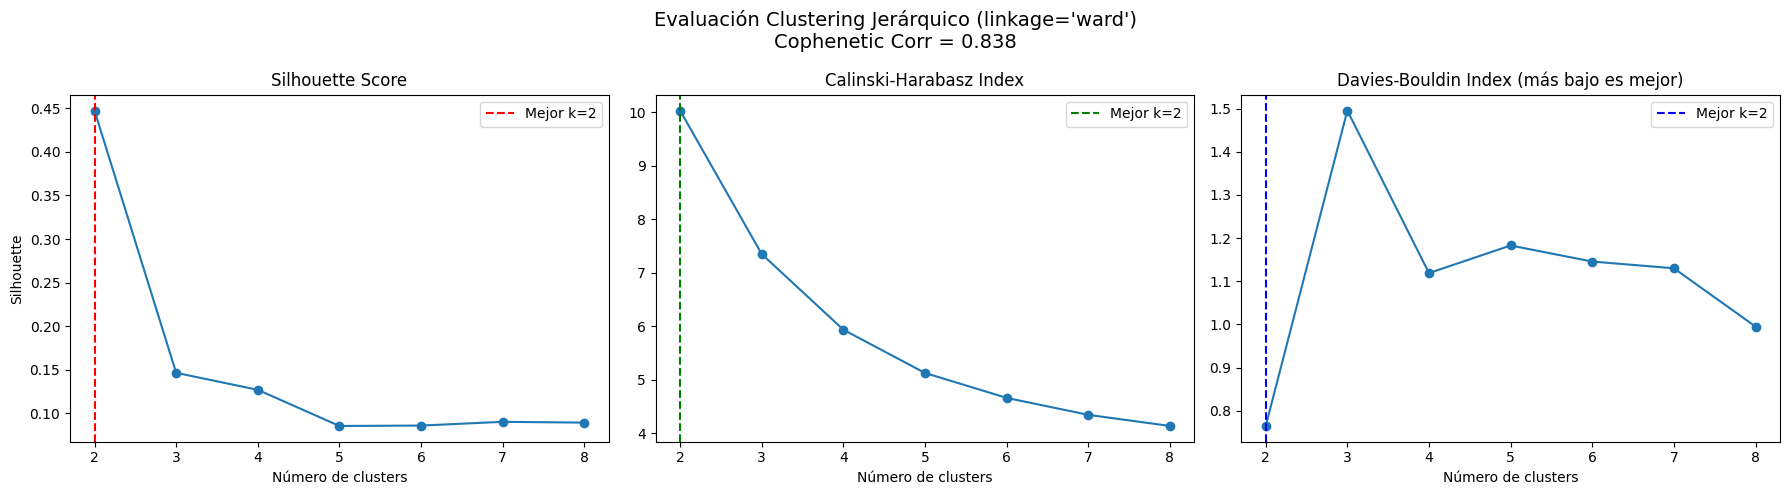

In [19]:
# 1. df_escalado_df = DataFrame escalado devuelto por preparar_datos_para_clustering
df_ligas = df_ready.copy()
df_ligas['liga'] = df['liga']  # añadir columna liga
#print(df_ligas.head())
print(df_ready.head())
# 2. Seleccionar solo columnas numéricas + liga
cols_numericas = df_ligas.select_dtypes(include=['number']).columns
df_ligas_numeric = df_ligas[cols_numericas].copy()
df_ligas_numeric['liga'] = df_ligas['liga']

# 3. Evaluar clustering global y por liga
res_global, coph_global, res_ligas, tabla_metricas = evaluar_por_liga(df_ligas_numeric, metodo="ward", rango_clusters=range(2,9))


In [21]:
tabla_metricas.to_csv(BASE_DIR / "output" / "metricas_clustering_normalizado.csv", index=False)

## Índices para datos por 90 minutos ##

   Tackles TklW_for  Tackles Def 3rd_for  Tackles Mid 3rd_for  \
0          9.157895             5.789474             6.552632   
1          9.789474             7.710526             6.552632   
2         10.500000             7.631579             7.868421   
3         10.000000             7.605263             5.868421   
4         11.342105             7.552632             7.815789   

   Tackles Att 3rd_for  Challenges Tkl_for  Challenges Lost_for  \
0             3.394737            6.842105             6.710526   
1             2.500000            8.157895             6.210526   
2             2.684211            7.921053             8.578947   
3             3.184211            8.263158             7.421053   
4             3.184211            9.210526             9.289474   

   Blocks Blocks_for  Blocks Sh_for  Blocks Pass_for  \
0           8.631579       2.789474         5.842105   
1           8.657895       2.815789         5.842105   
2          12.078947       3.578947   

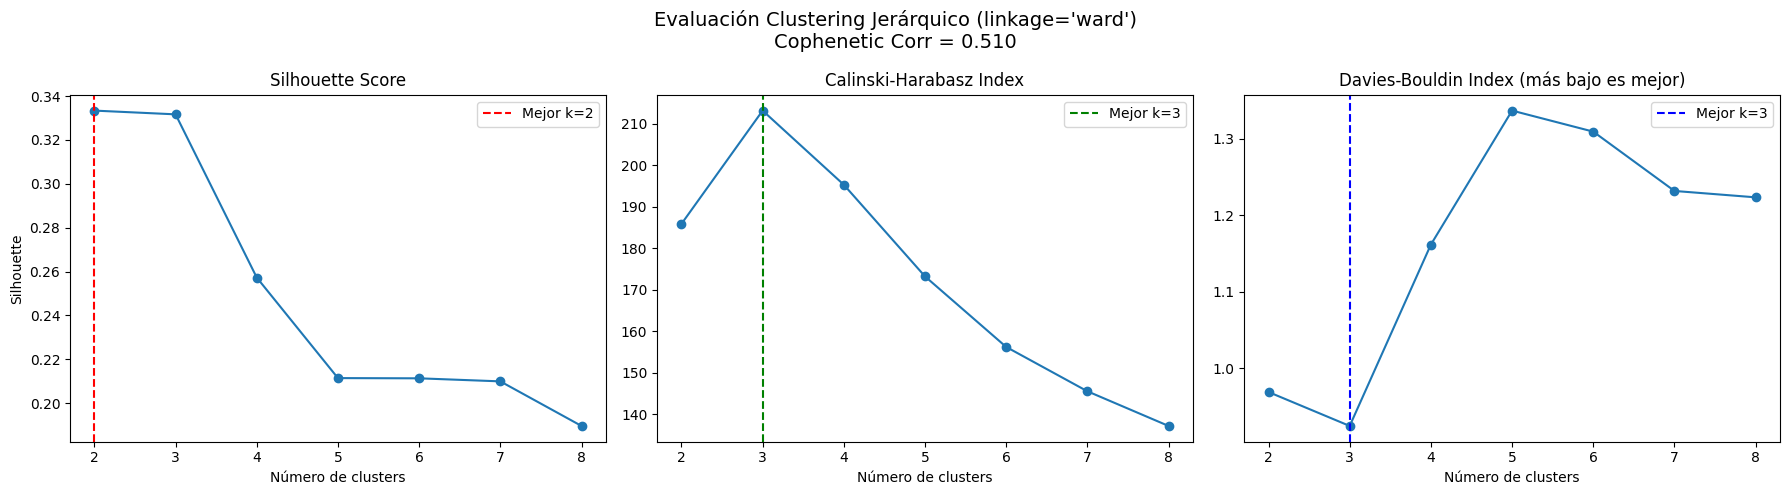


=== Análisis Premier League ===


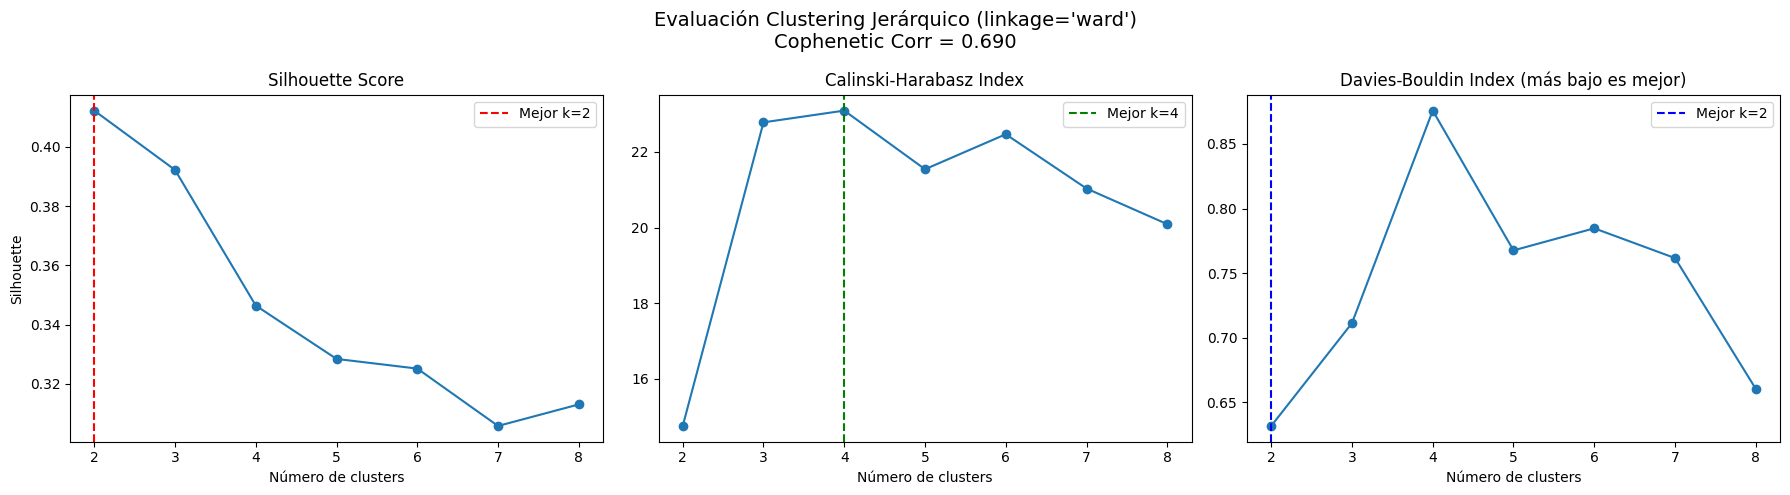


=== Análisis Serie A ===


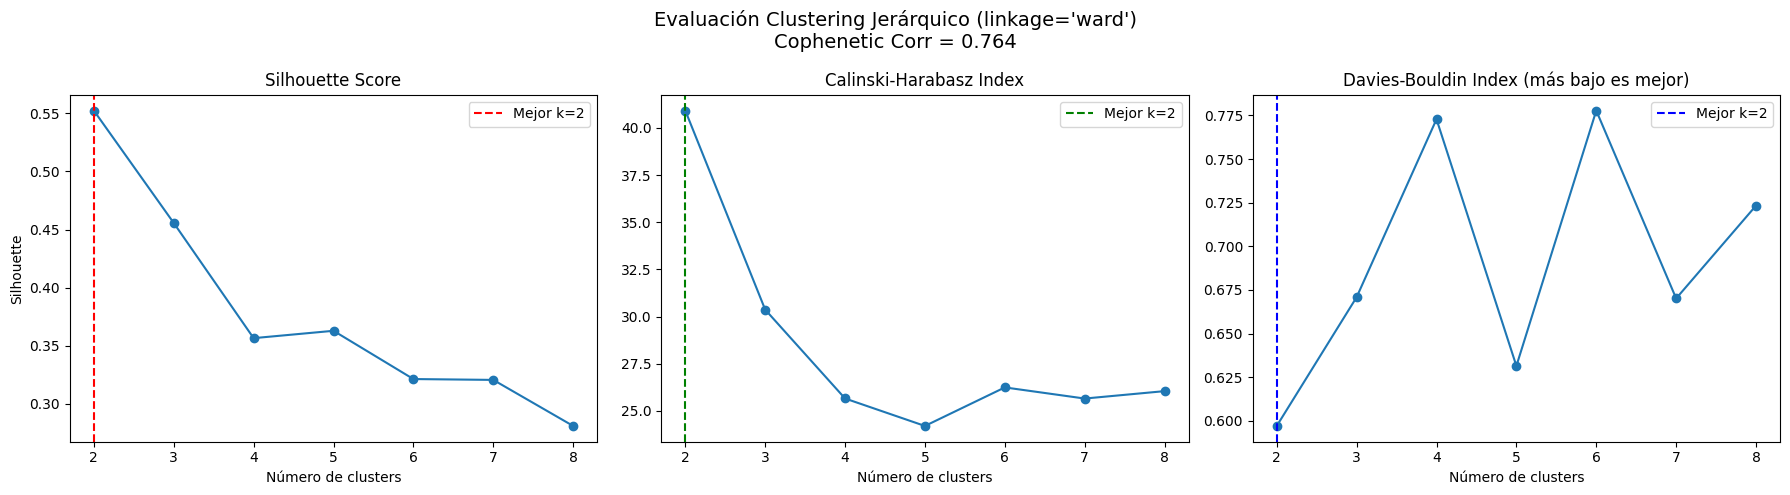


=== Análisis Ligue 1 ===


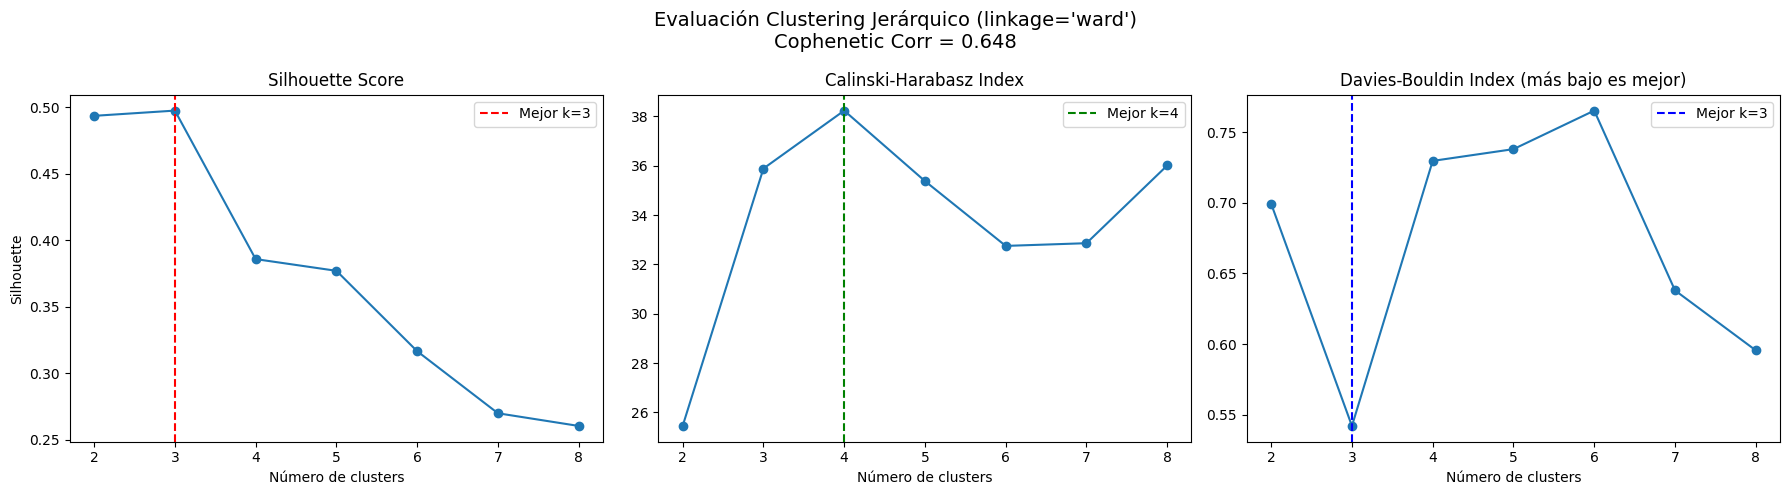


=== Análisis Bundesliga ===


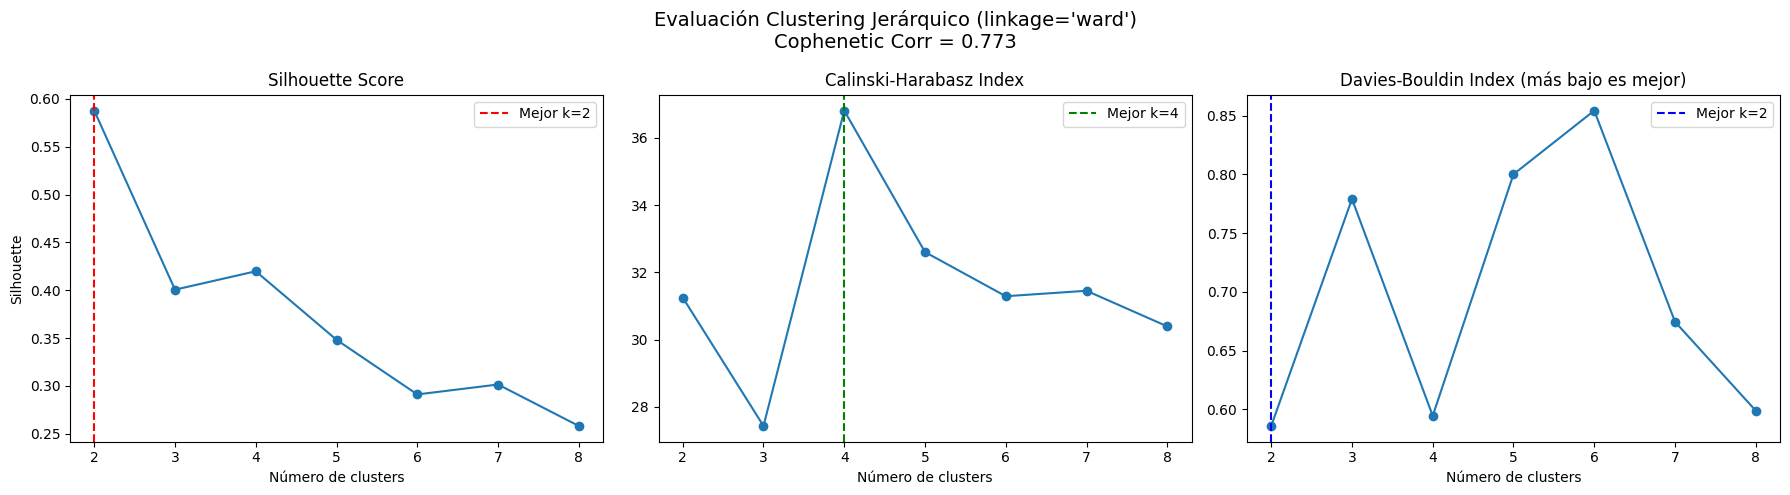


=== Análisis La Liga ===


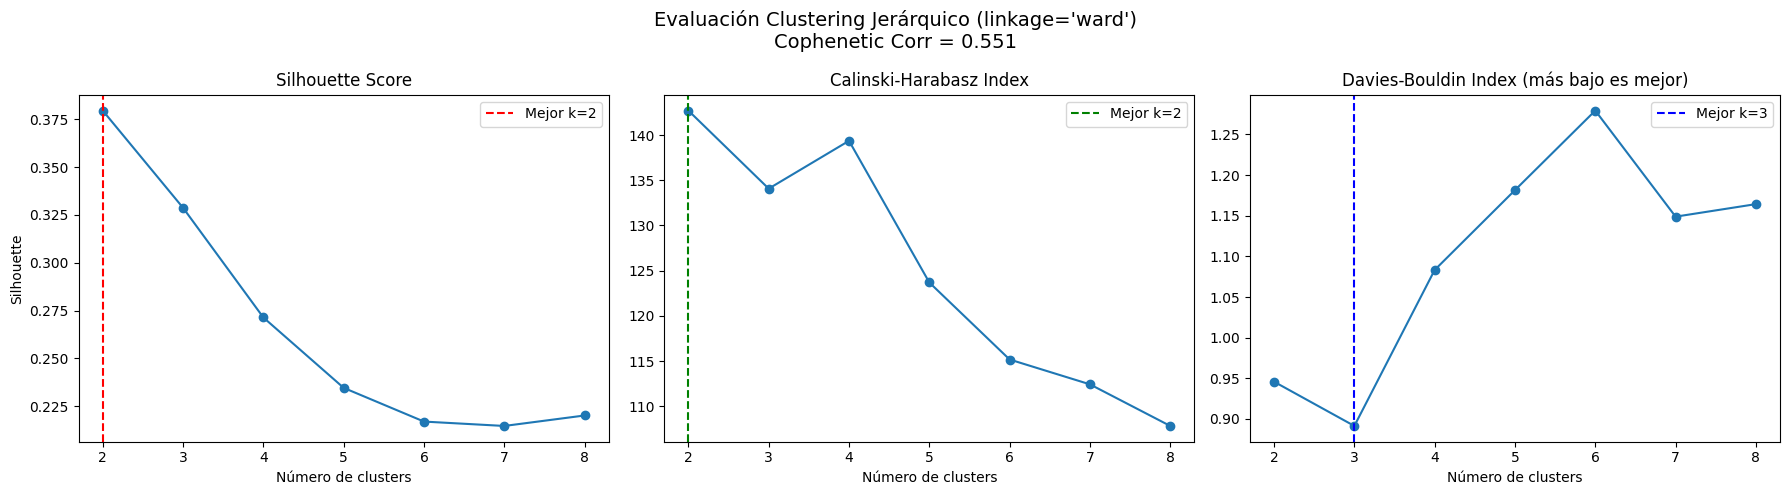


=== Análisis Femenino ===


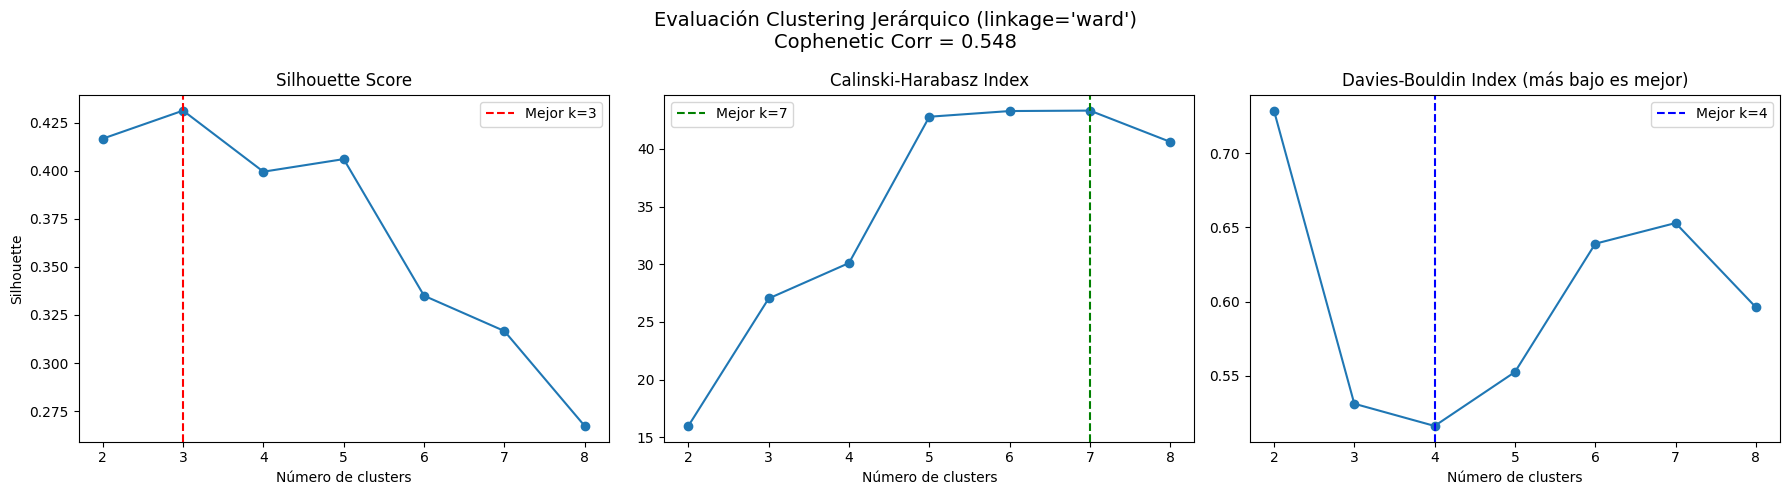

In [22]:
# 1. df_escalado_df = DataFrame escalado devuelto por preparar_datos_para_clustering
df_ligas_90 = X_90.copy()
df_ligas_90['liga'] = df['liga']  # añadir columna liga
#print(df_ligas.head())
print(X_90.head())
# 2. Seleccionar solo columnas numéricas + liga
cols_numericas = df_ligas_90.select_dtypes(include=['number']).columns
df_ligas_90numeric = df_ligas_90[cols_numericas].copy()
df_ligas_90numeric['liga'] = df_ligas_90['liga']

# 3. Evaluar clustering global y por liga
res_global, coph_global, res_ligas, tabla_metricas_90 = evaluar_por_liga(df_ligas_90numeric, metodo="ward", rango_clusters=range(2,9))

In [23]:
tabla_metricas_90.to_csv(BASE_DIR / "output" / "metricas_clustering_90.csv", index=False)

## Diccionario de número de clústeres ##

In [ ]:
# Configuración de ligas y número de clusters óptimo
ligas_config = {
    'Femenino': {
        'Por 90 min': {'clusters': 3},
        'Normalizado': {'clusters': 4}
    },
    'La Liga': {
        'Por 90 min': {'clusters': 3},
        'Normalizado': {'clusters': 4}
    },
    'Bundesliga': {
        'Por 90 min': {'clusters': 4},
        'Normalizado': {'clusters': 3}
    },
    'Ligue 1': {
        'Por 90 min': {'clusters': 3},
        'Normalizado': {'clusters': 2}
    },
    'Serie A': {
        'Por 90 min': {'clusters': 5},
        'Normalizado': {'clusters': 3}
    },
    'Premier League': {
        'Por 90 min': {'clusters': 3},
        'Normalizado': {'clusters': 3}
    },
    'Global': {
        'Por 90 min': {'clusters': 3},
        'Normalizado': {'clusters': 3}
    }
}


In [15]:
# Guardar resultados
df.to_csv('resultados_clustering_con_clusters.csv', index=False)

# Mostrar distribución de clusters por liga
print("\nDistribución de clusters por liga:")
for liga, tipos in ligas_config.items():
    for tipo in tipos.keys():
        columna_cluster = f'Cluster_{liga}_{tipo.replace(" ", "_")}'
        
        if columna_cluster in df.columns:
            print(f"\n{liga} ({tipo}):")
            print(df[columna_cluster].value_counts().sort_index())
        else:
            print(f"\nNo hay datos de clusters para {liga} ({tipo})")

# --------------------------
# Visualizar algunas características de los clusters (ejemplo)
# --------------------------

columna_global = 'Cluster_Global_Por_90_min'  # nombre que generaste arriba

if columna_global in df.columns:
    # Construir lista de columnas de clusters dinámicamente
    cluster_cols = []
    for liga, tipos in ligas_config.items():
        for tipo in tipos.keys():
            cluster_cols.append(f'Cluster_{liga}_{tipo.replace(" ", "_")}')

    # Seleccionar columnas numéricas de interés
    columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
    columnas_interes = [col for col in columnas_numericas if col not in ['season', 'Squad', 'liga'] + cluster_cols]

    # Tomar las primeras 5 columnas de interés
    if len(columnas_interes) > 5:
        columnas_interes = columnas_interes[:5]

    # Calcular promedios por cluster
    promedios_clusters = df.groupby(columna_global)[columnas_interes].mean()

    # Visualizar
    plt.figure(figsize=(12, 6))
    promedios_clusters.plot(kind='bar')
    plt.title('Promedio de variables por cluster (Global)')
    plt.xlabel('Cluster')
    plt.ylabel('Valor promedio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('promedios_clusters_global.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Análisis completado. Resultados guardados en 'resultados_clustering_con_clusters.csv'")



Distribución de clusters por liga:

No hay datos de clusters para Femenino (Por 90 min)

No hay datos de clusters para Femenino (Normalizado)

No hay datos de clusters para La Liga (Por 90 min)

No hay datos de clusters para La Liga (Normalizado)

No hay datos de clusters para Bundesliga (Por 90 min)

No hay datos de clusters para Bundesliga (Normalizado)

No hay datos de clusters para Ligue 1 (Por 90 min)

No hay datos de clusters para Ligue 1 (Normalizado)

No hay datos de clusters para Serie A (Por 90 min)

No hay datos de clusters para Serie A (Normalizado)

No hay datos de clusters para Premier League (Por 90 min)

No hay datos de clusters para Premier League (Normalizado)

No hay datos de clusters para Global (Por 90 min)

No hay datos de clusters para Global (Normalizado)
Análisis completado. Resultados guardados en 'resultados_clustering_con_clusters.csv'


In [14]:
for liga, tipos in ligas_config.items():
    for tipo, config in tipos.items():
        n_clusters = config['clusters']
        
        print(f"Procesando {liga} con {n_clusters} clusters ({tipo})...")
        
        # Preparar datos
        if liga == 'Global':
            df_liga = df.copy()
        else:
            df_liga = df[df['liga'] == liga].copy()
        
        X, _, _ = preparar_datos_para_clustering(
            df_liga, 
            columnas_excluir=['season', 'Squad', 'liga'],
            normalizar_por_jornadas=(tipo == 'Por 90 min')
        )
        
        # Etiquetas
        labels = df_liga['Squad'].values
        
        # Generar dendrograma
        titulo = f'Dendrograma - {liga} ({tipo}) - {n_clusters} clusters'
        linkage_matrix = dendograma_jerarquico(
            X, 
            metodo='ward', 
            titulo=titulo,
            n_clusters=n_clusters,
            labels=labels
        )
        
        # Clusters
        clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
        
        # Guardar
        df.loc[df_liga.index, f'Cluster_{liga}_{tipo.replace(" ", "_")}'] = clusters


# Guardar resultados
df.to_csv('resultados_clustering_con_clusters.csv', index=False)

# Mostrar distribución de clusters por liga
print("\nDistribución de clusters por liga:")
for liga, config in ligas_config.items():
    tipo = config['tipo']
    columna_cluster = f'Cluster_{liga}_{tipo}'
    
    if columna_cluster in df.columns:
        print(f"\n{liga} ({tipo}):")
        print(df[columna_cluster].value_counts().sort_index())
    else:
        print(f"\nNo hay datos de clusters para {liga}")

# Visualizar algunas características de los clusters (ejemplo)
if 'Cluster_Global_Por 90 min' in df.columns:
    # Seleccionar algunas columnas numéricas para visualizar
    columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
    columnas_interes = [col for col in columnas_numericas if col not in 
                       ['season', 'Squad', 'liga', 'season'] + 
                      # Construir dinámicamente los nombres de columnas de clusters
cluster_cols = []
for liga, tipos in ligas_config.items():
    for tipo in tipos.keys():
        cluster_cols.append(f'Cluster_{liga}_{tipo.replace(" ", "_")}')]
    
    # Tomar las primeras 5 columnas de interés
    if len(columnas_interes) > 5:
        columnas_interes = columnas_interes[:5]
    
    # Calcular promedios por cluster
    promedios_clusters = df.groupby('Cluster_Global_Por 90 min')[columnas_interes].mean()
    
    # Visualizar
    plt.figure(figsize=(12, 6))
    promedios_clusters.plot(kind='bar')
    plt.title('Promedio de variables por cluster (Global)')
    plt.xlabel('Cluster')
    plt.ylabel('Valor promedio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('promedios_clusters_global.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Análisis completado. Resultados guardados en 'resultados_clustering_con_clusters.csv'")

SyntaxError: invalid syntax (2282535289.py, line 61)